In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
from scipy.stats import chi2

def chi_squared_between_suites(
    base_dir,
    suite_names,
    quantity="Q_r",       # Options: "Q_r", "Q_tot", "slope_Q_r", "slope_Q_tot"
    coord="r",            # "r" = radius; "m" = enclosed mass
    x_range=None,         # Tuple (xmin, xmax) to limit the x-range for comparison
    n_points=100,         # Number of interpolation points on common grid
    plot=True,            # If True, show comparison plots
):
    x_key = "r_scaled" if coord == "r" else "m_scaled"
    is_slope = quantity.startswith("slope_")
    suite_data = {}
    global_x_min = np.inf
    global_x_max = -np.inf

    for suite in suite_names:
        x_stack, y_stack = [], []

        if is_slope:
            slope_dir = os.path.join(base_dir, "output", suite, f"ppsd_slope_profiles_{coord}")
            files = sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv") and f.startswith("halo_"))

            for f in files:
                try:
                    df = pd.read_csv(os.path.join(slope_dir, f))
                    if x_key not in df.columns or quantity not in df.columns:
                        continue
                    x = df[x_key].values
                    y = df[quantity].values
                    x_stack.append(x)
                    y_stack.append(y)

                    valid_x = x[np.isfinite(x)]
                    if valid_x.size > 0:
                        global_x_min = min(global_x_min, valid_x.min())
                        global_x_max = max(global_x_max, valid_x.max())
                except Exception as e:
                    print(f"[Warning] Failed to read slope {f}: {e}")
                    continue
        else:
            profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
            files = sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv"))

            for f in files:
                df = pd.read_csv(os.path.join(profile_dir, f))
                if x_key not in df.columns or quantity not in df.columns:
                    continue
                x = df[x_key].values
                y = df[quantity].values
                x_stack.append(x)
                y_stack.append(y)

                valid_x = x[np.isfinite(x)]
                if valid_x.size > 0:
                    global_x_min = min(global_x_min, valid_x.min())
                    global_x_max = max(global_x_max, valid_x.max())

        if len(x_stack) == 0:
            raise RuntimeError(f"No valid profiles found for suite {suite}")

        suite_data[suite] = {"x_stack": x_stack, "y_stack": y_stack}

    # Step 2: Interpolation grid
    xmin, xmax = x_range
    
    x_common = np.logspace(np.log10(xmin), np.log10(xmax), n_points)
    # Step 3: Interpolate and average
    for suite in suite_names:
        y_interp_all = []
        for x_arr, y_arr in zip(suite_data[suite]["x_stack"], suite_data[suite]["y_stack"]):
            y_interp = np.interp(x_common, x_arr, y_arr, left=np.nan, right=np.nan)
            y_interp_all.append(y_interp)
        y_interp_all = np.array(y_interp_all)

        suite_data[suite]["x"] = x_common
        suite_data[suite]["mean"] = np.nanmean(y_interp_all, axis=0)
        suite_data[suite]["std"] = np.nanstd(y_interp_all, axis=0)

    # Step 4: χ² test
    results = {}
    for s1, s2 in itertools.combinations(suite_names, 2):
        d1, d2 = suite_data[s1], suite_data[s2]
        x = d1["x"]
        μ1, σ1 = d1["mean"], d1["std"]
        μ2, σ2 = d2["mean"], d2["std"]

        valid = np.isfinite(μ1) & np.isfinite(μ2) & (σ1 + σ2 > 0)
        if x_range is not None:
            valid &= (x >= xmin) & (x <= xmax)

        ν = np.sum(valid)
        if ν < 5:
            print(f"[Warning] Too few valid points for {s1} vs {s2}")
            continue

        χ2_val = np.sum((μ1[valid] - μ2[valid])**2 / (σ1[valid]**2 + σ2[valid]**2))
        p_val = 1 - chi2.cdf(χ2_val, ν)

        results[(s1, s2)] = {"chi2": χ2_val, "dof": ν, "pval": p_val}

        if plot:
            plt.figure(figsize=(6, 4), dpi=400)
            plt.errorbar(x[valid], μ1[valid], yerr=σ1[valid], fmt="-o", label=s1, markersize=3, capsize=2)
            plt.errorbar(x[valid], μ2[valid], yerr=σ2[valid], fmt="-s", label=s2, markersize=3, capsize=2)
            plt.xscale("log")
            plt.xlabel(f"{coord.upper()} (scaled)")
            plt.ylabel(quantity)
            plt.title(f"{s1} vs {s2}  |  χ²={χ2_val:.1f}, ν={ν}, p={p_val:.3g}")
            plt.grid(True, which="both", ls=":")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results

In [ ]:
import itertools
from scipy.stats import ks_2samp

def ks_test_profilewise_between_suites_with_significance(
    base_dir,
    suite_names,
    quantity="Q_r",
    coord="r",
    x_range=None,
    n_points=100,
    plot=True,
    significance_levels=[0.05, 0.01]  # Mark thresholds for statistical significance
):
    x_key = "r_scaled" if coord == "r" else "m_scaled"
    is_slope = quantity.startswith("slope_")
    suite_data = {}
    global_x_min = np.inf
    global_x_max = -np.inf

    for suite in suite_names:
        x_stack, y_stack = [], []

        if is_slope:
            slope_dir = os.path.join(base_dir, "output", suite, f"ppsd_slope_profiles_{coord}")
            files = sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv") and f.startswith("halo_"))
        else:
            profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
            files = sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv"))

        for f in files:
            try:
                path = os.path.join(slope_dir if is_slope else profile_dir, f)
                df = pd.read_csv(path)
                if x_key not in df.columns or quantity not in df.columns:
                    continue
                x = df[x_key].values
                y = df[quantity].values
                x_stack.append(x)
                y_stack.append(y)
                valid_x = x[np.isfinite(x)]
                if valid_x.size > 0:
                    global_x_min = min(global_x_min, valid_x.min())
                    global_x_max = max(global_x_max, valid_x.max())
            except Exception as e:
                print(f"[Warning] Failed to read {f}: {e}")
                continue

        if len(x_stack) == 0:
            raise RuntimeError(f"No valid profiles found for suite {suite}")

        suite_data[suite] = {"x_stack": x_stack, "y_stack": y_stack}

    if x_range is None:
        xmin, xmax = global_x_min, global_x_max
    else:
        xmin, xmax = x_range

    x_common = np.logspace(np.log10(xmin), np.log10(xmax), n_points)

    for suite in suite_names:
        y_interp_all = []
        for x_arr, y_arr in zip(suite_data[suite]["x_stack"], suite_data[suite]["y_stack"]):
            y_interp = np.interp(x_common, x_arr, y_arr, left=np.nan, right=np.nan)
            y_interp_all.append(y_interp)
        suite_data[suite]["y_interp_all"] = np.array(y_interp_all)

    results = {}
    for s1, s2 in itertools.combinations(suite_names, 2):
        y1_all = suite_data[s1]["y_interp_all"]
        y2_all = suite_data[s2]["y_interp_all"]

        ks_stats = []
        p_values = []
        for i in range(n_points):
            v1 = y1_all[:, i]
            v2 = y2_all[:, i]
            v1 = v1[np.isfinite(v1)]
            v2 = v2[np.isfinite(v2)]

            if len(v1) < 5 or len(v2) < 5:
                ks_stats.append(np.nan)
                p_values.append(np.nan)
                continue

            ks_stat, p_val = ks_2samp(v1, v2)
            ks_stats.append(ks_stat)
            p_values.append(p_val)

        ks_stats = np.array(ks_stats)
        p_values = np.array(p_values)

        results[(s1, s2)] = {
            "x": x_common,
            "ks_stat": ks_stats,
            "pval": p_values,
        }

        if plot:
            fig, ax1 = plt.subplots(figsize=(8, 4), dpi=150)
            ax1.plot(x_common, ks_stats, label="KS statistic", color="tab:blue", lw=2)
            ax1.set_xscale("log")
            ax1.set_xlabel(f"{coord.upper()} (scaled)")
            ax1.set_ylabel("KS statistic", color="tab:blue")
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax1.grid(True, which="both", ls=":")

            ax2 = ax1.twinx()
            ax2.plot(x_common, p_values, label="p-value", color="tab:red", lw=1.8)
            for sig in significance_levels:
                ax2.axhline(sig, color="gray", ls="--", lw=0.8, label=f"p = {sig}")
            ax2.set_ylabel("p-value", color="tab:red")
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax2.set_yscale("log")

            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc="upper right")

            plt.title(f"KS Test: {s1} vs {s2}")
            fig.tight_layout()
            plt.show()

    return results

            Suite 1           Suite 2  KS_c_norm_stat  p_c_norm
0       SymphonyLMC  SymphonyMilkyWay        0.157265  0.610778
1       SymphonyLMC     SymphonyGroup        0.152276  0.622273
2       SymphonyLMC  SymphonyLCluster        0.128205  0.884540
3       SymphonyLMC   SymphonyCluster        0.144349  0.583989
4  SymphonyMilkyWay     SymphonyGroup        0.099773  0.944818
5  SymphonyMilkyWay  SymphonyLCluster        0.191919  0.422442
6  SymphonyMilkyWay   SymphonyCluster        0.123457  0.721151
7     SymphonyGroup  SymphonyLCluster        0.134818  0.808603
8     SymphonyGroup   SymphonyCluster        0.074578  0.988846
9  SymphonyLCluster   SymphonyCluster        0.126824  0.790308
            Suite 1           Suite 2  KS_gamma_norm_stat  p_gamma_norm
0       SymphonyLMC  SymphonyMilkyWay            0.129987      0.837321
1       SymphonyLMC     SymphonyGroup            0.155084      0.655373
2       SymphonyLMC  SymphonyLCluster            0.182214      0.547504
3       

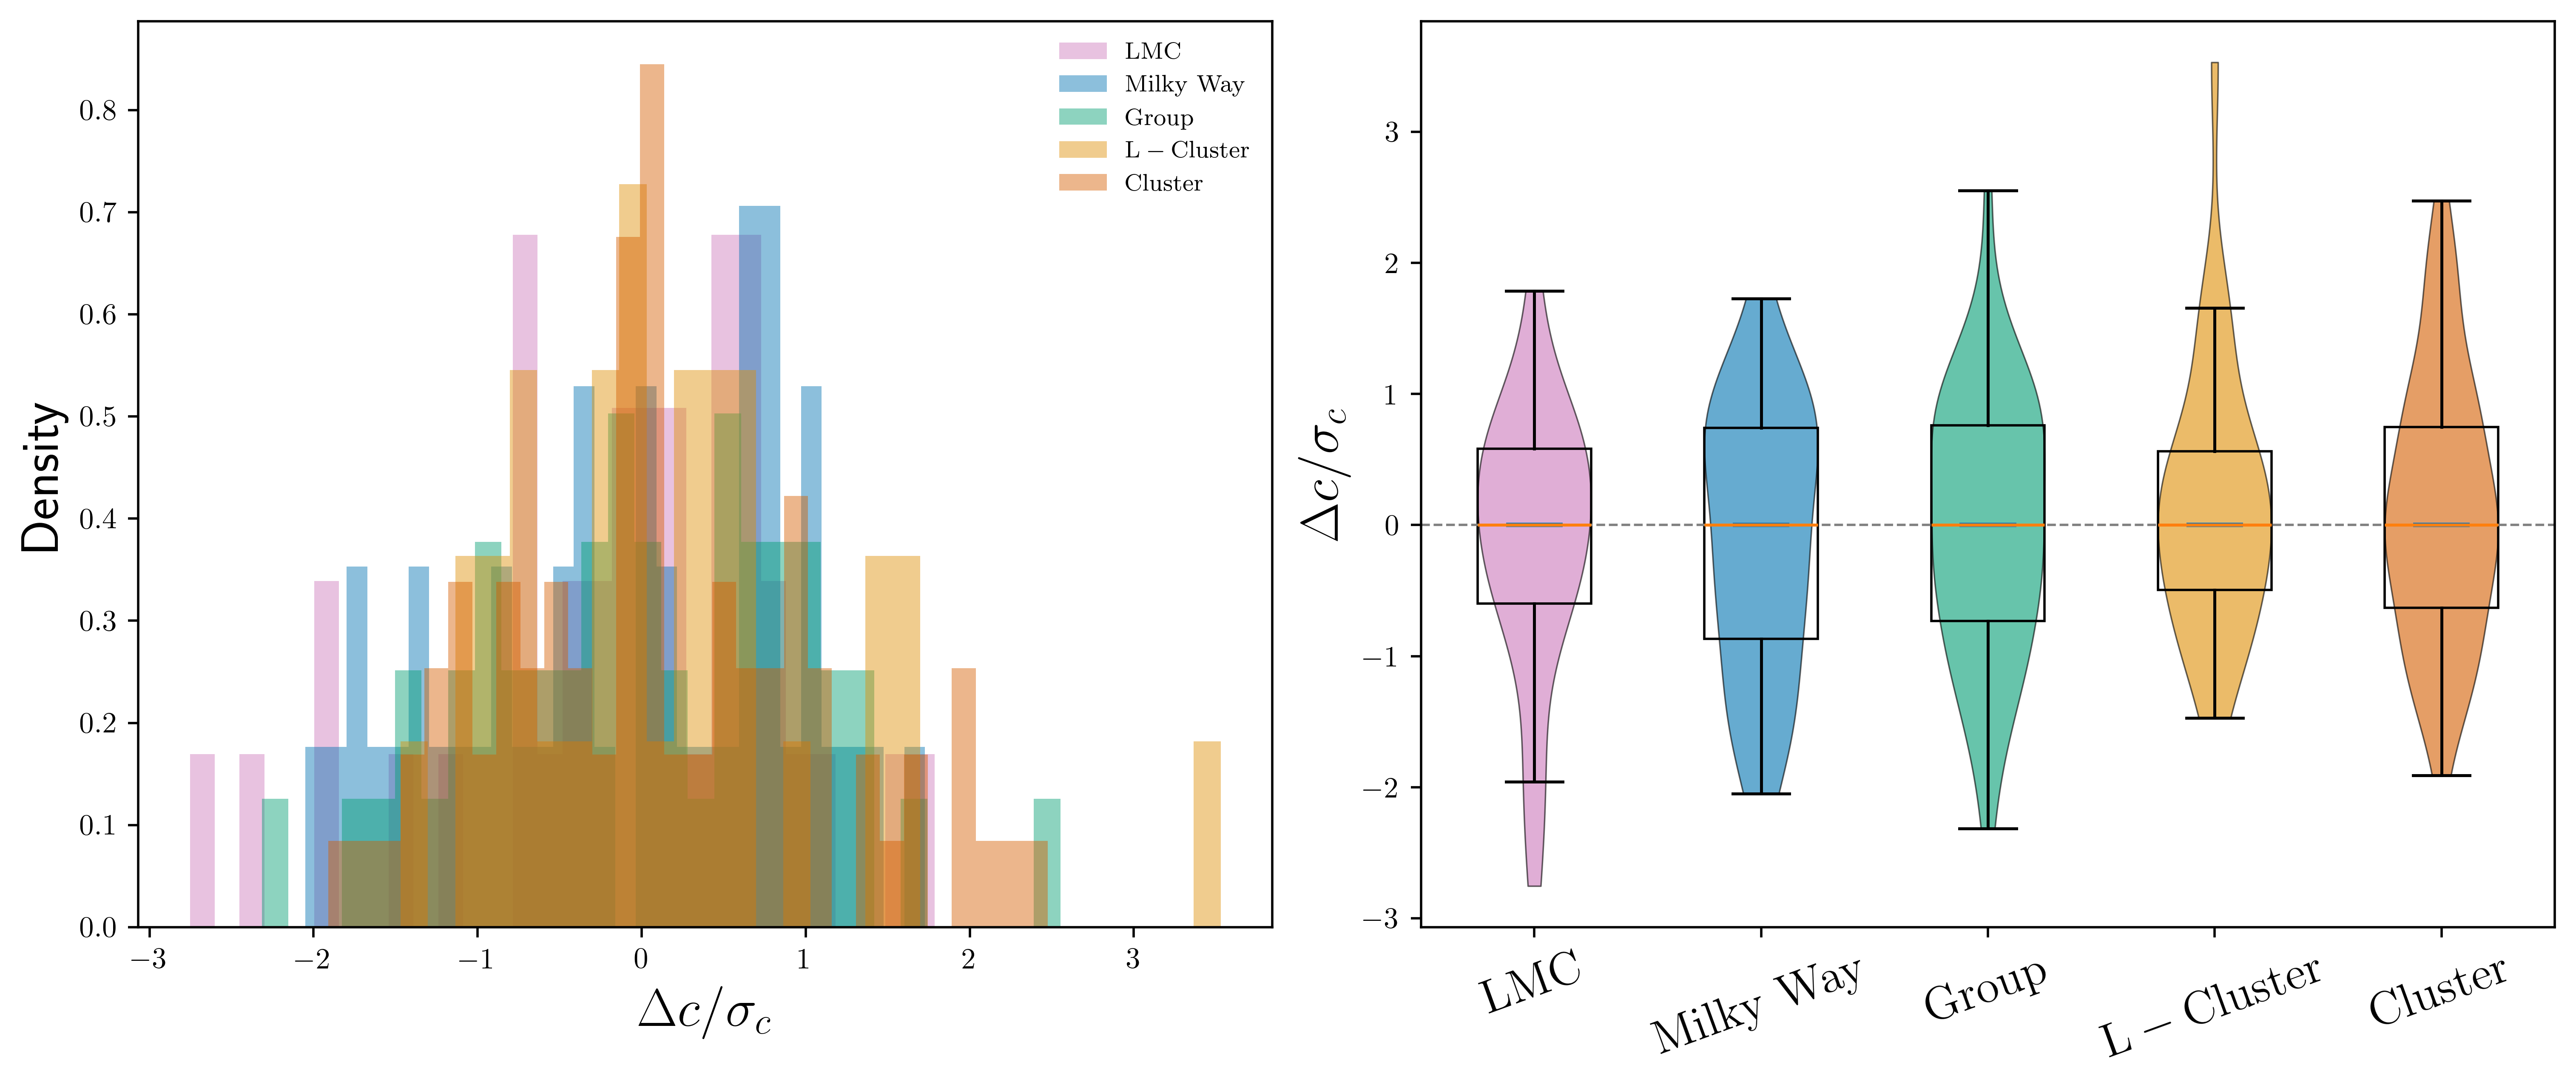

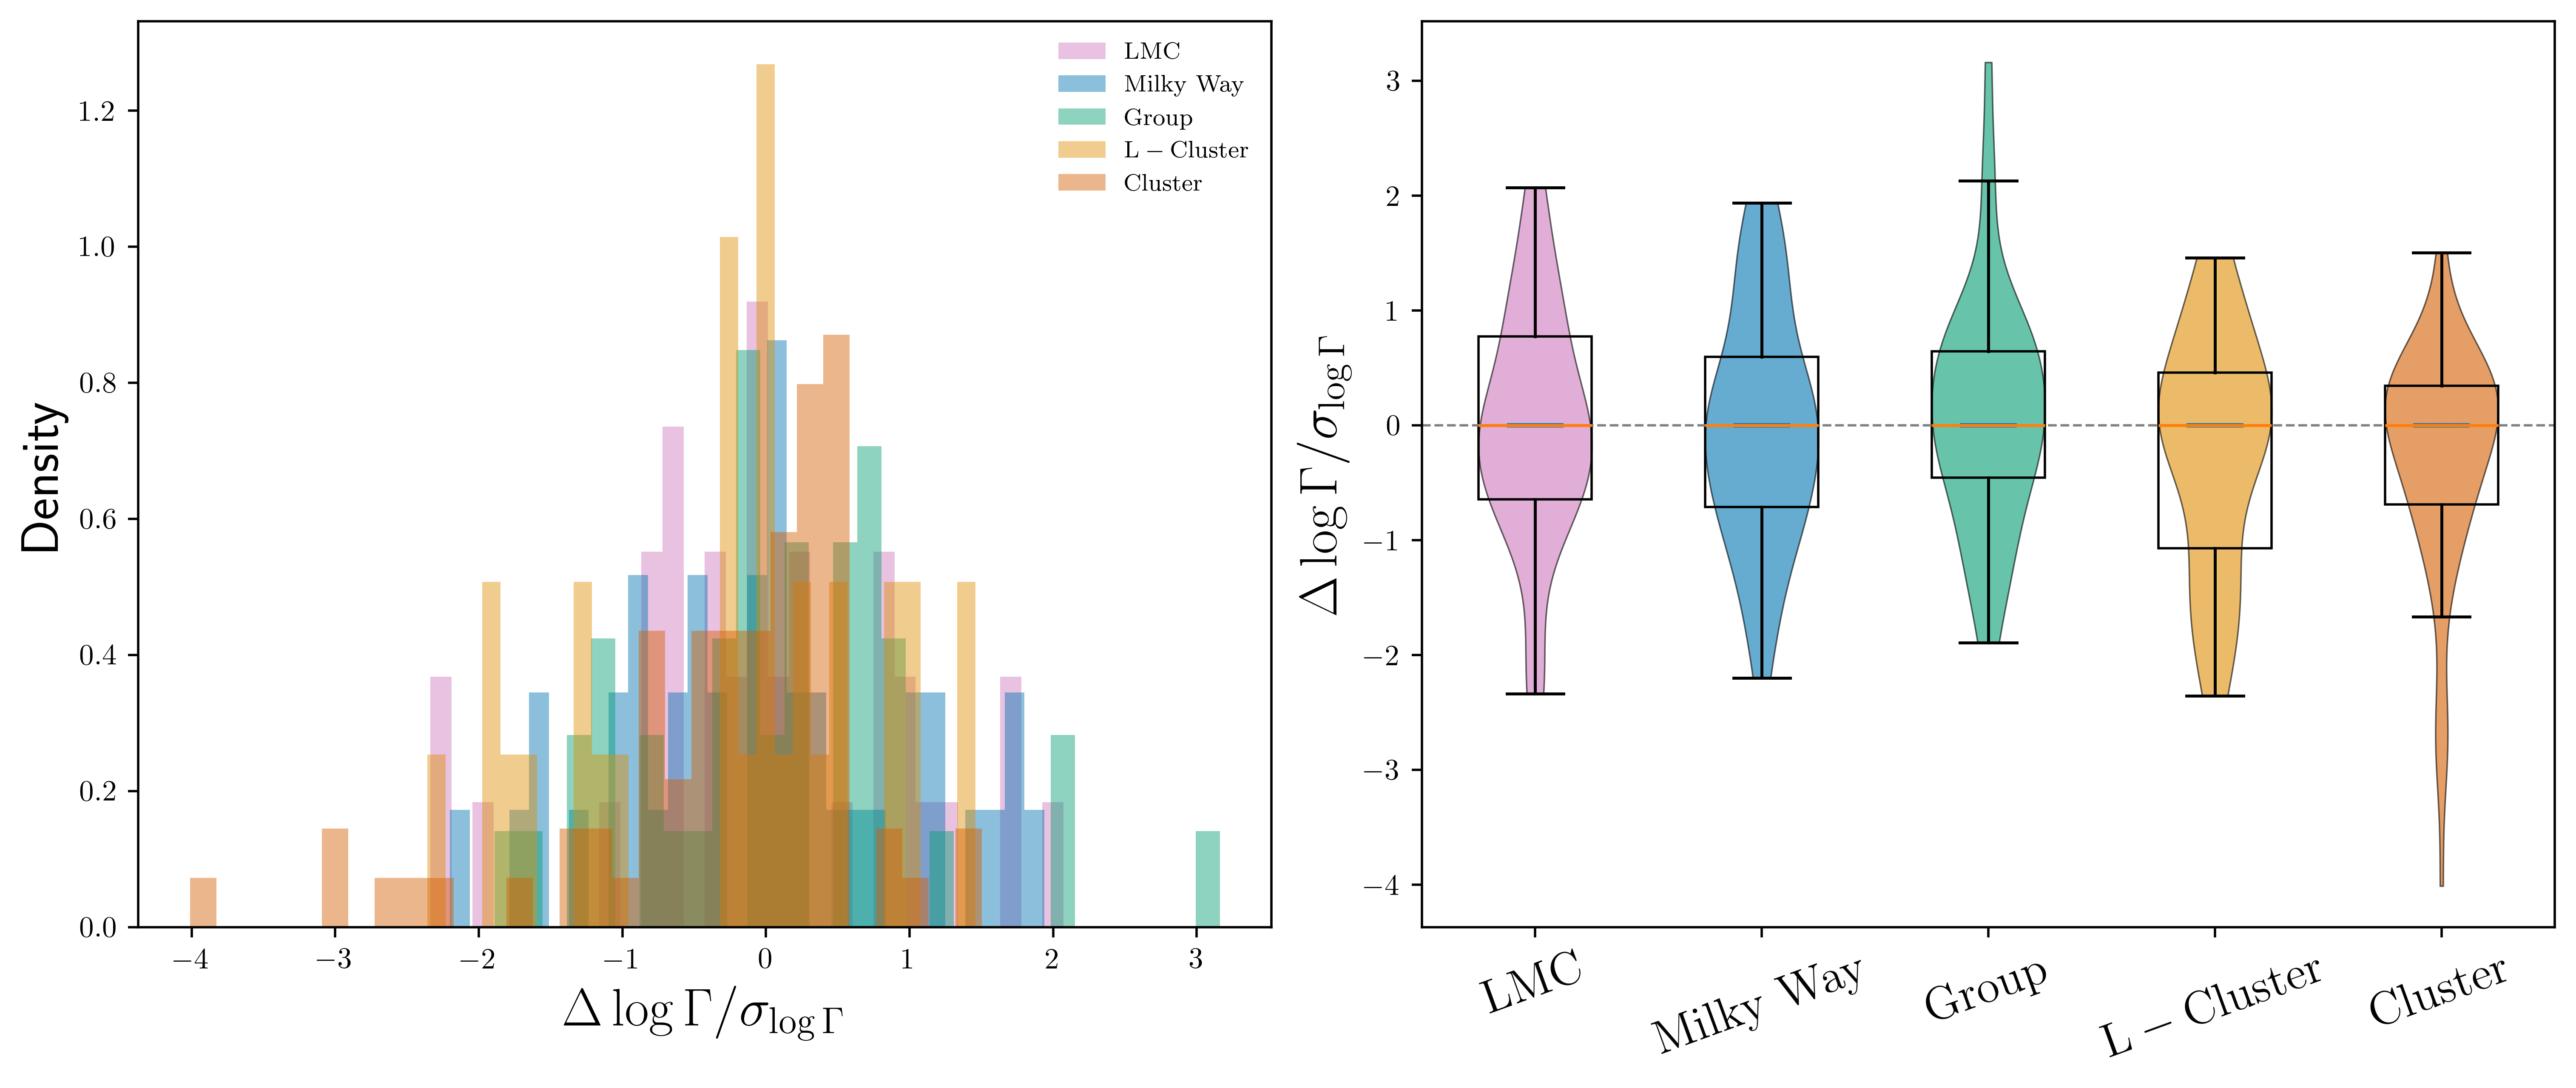

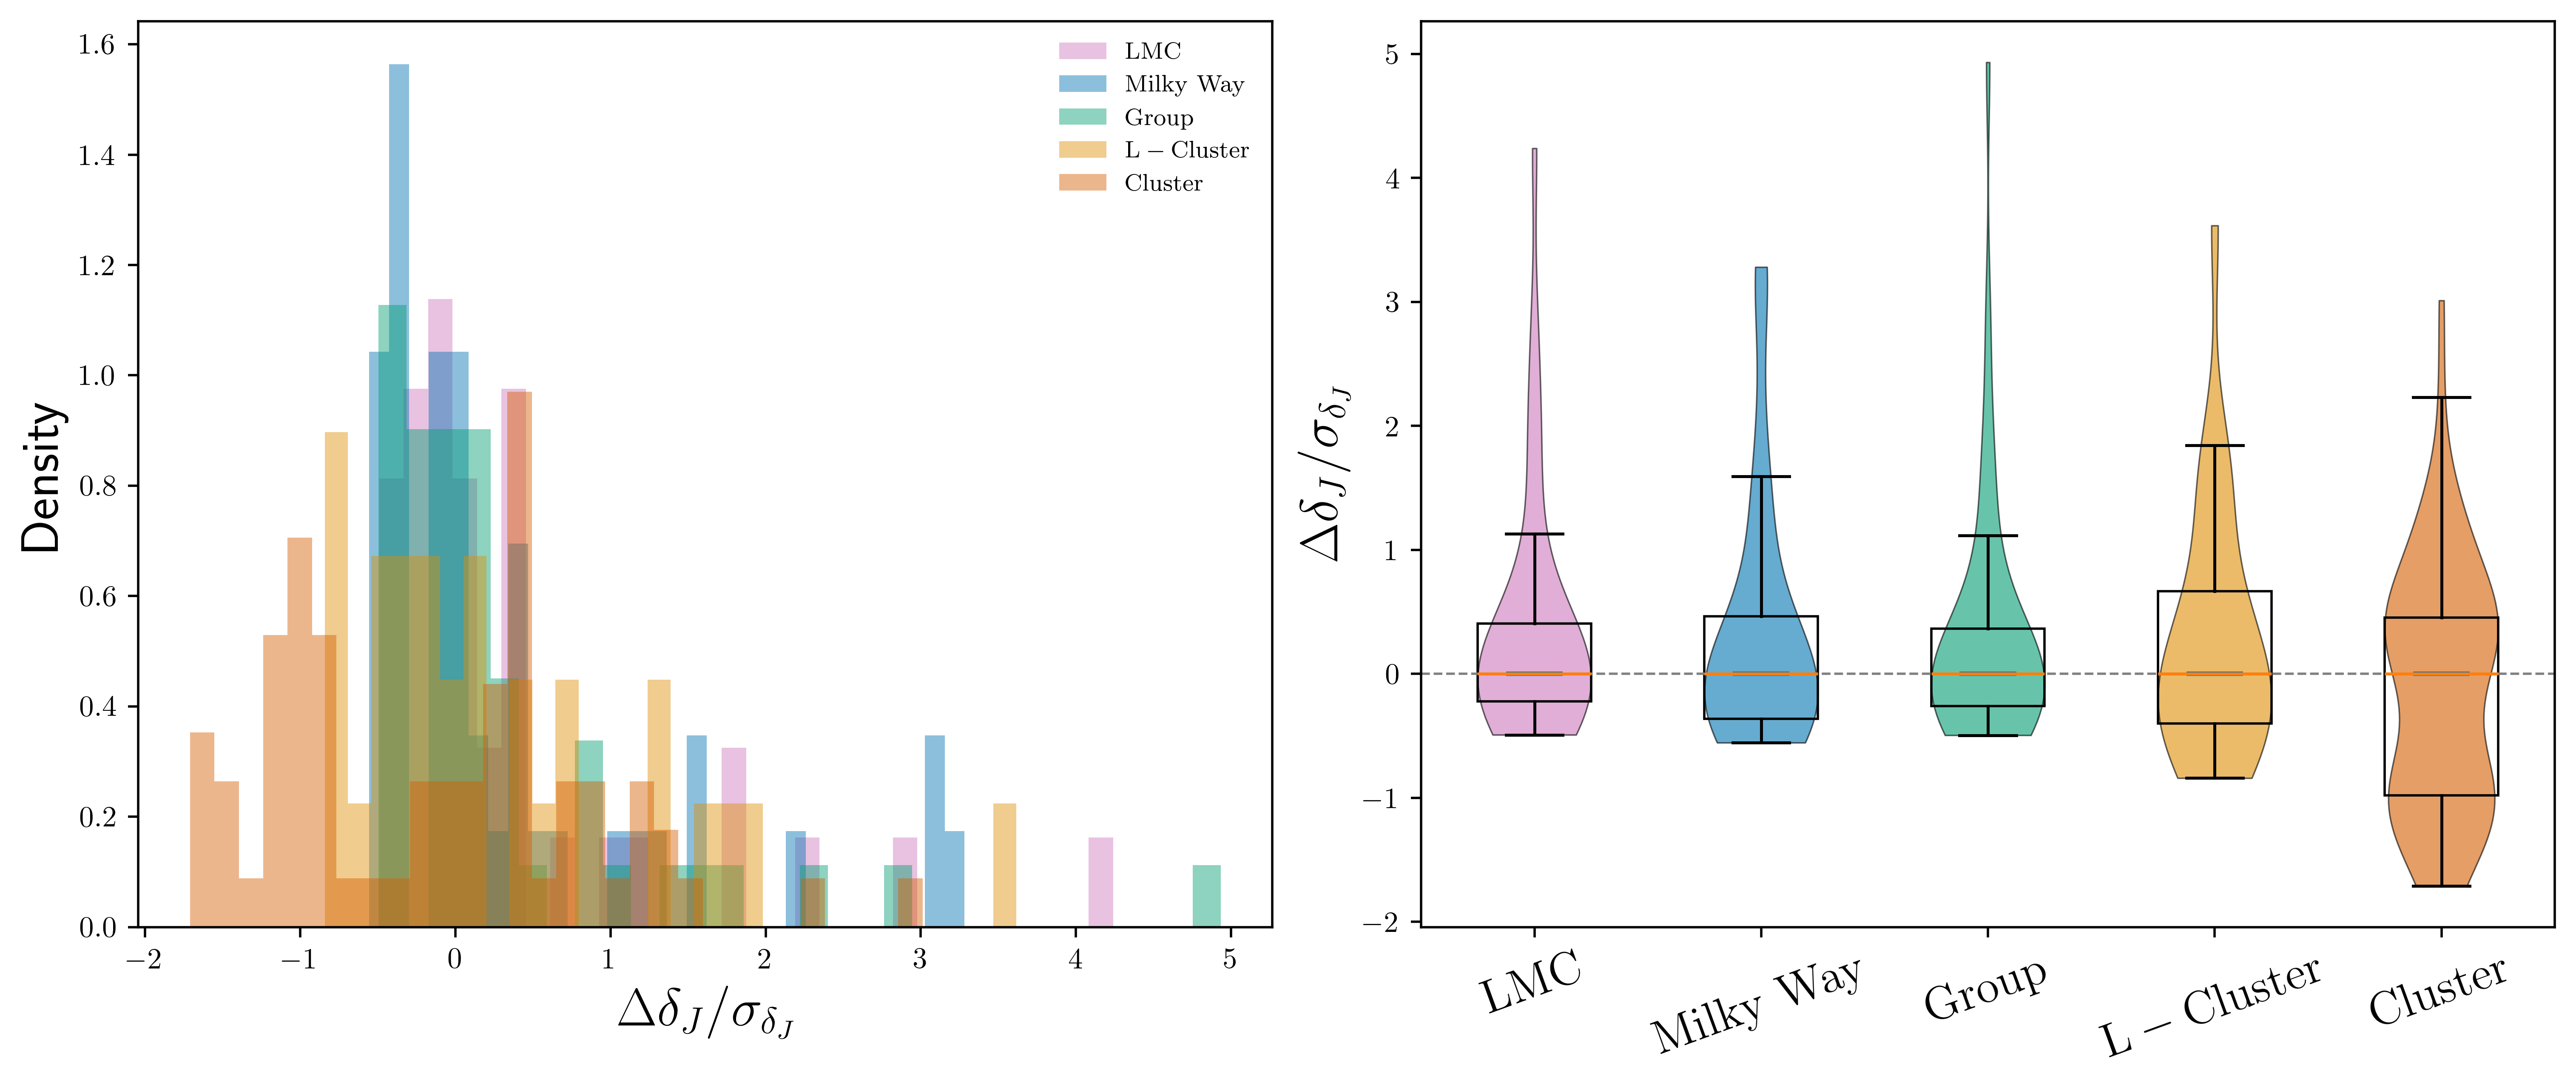

In [5]:
import itertools
from scipy.stats import ks_2samp

def load_delta_jeans_norm(suite):
    path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
    df = pd.read_csv(path)
    dJ = pd.to_numeric(df["delta_J_tot"], errors='coerce').dropna()
    return ((dJ - dJ.median()) / dJ.std()).values

def load_delta_c_norm(suite):
    path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
    df = pd.read_csv(path)
    c = pd.to_numeric(df["cvir"], errors='coerce').dropna()
    median_c = c.median()
    std_c = c.std()
    return ((c - median_c) / std_c).values

def load_delta_gamma_norm(suite):
    path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
    df = pd.read_csv(path)
    g = pd.to_numeric(df["gamma"], errors='coerce').dropna()
    gpos = g[g > 0]
    logg = np.log10(gpos)
    median_logg = np.median(logg)
    std_logg = np.std(logg)
    return ((logg - median_logg) / std_logg).values

def consistency_panel(metric_name):
    # Pick loader
    loaders = {
        "c_norm":     load_delta_c_norm,
        "gamma_norm": load_delta_gamma_norm,
        "jeans_norm": load_delta_jeans_norm,
    }
    loader = loaders[metric_name]

    # Load data for all suites
    data_dict = {s: loader(s) for s in suite_names}

    # KS tests
    rows = []
    for s1, s2 in itertools.combinations(suite_names, 2):
        D, p = ks_2samp(data_dict[s1], data_dict[s2])
        rows.append([s1, s2, D, p])
    ks_df = pd.DataFrame(rows, columns=["Suite 1", "Suite 2",
                                        f"KS_{metric_name}_stat", f"p_{metric_name}"])
    print(ks_df)
    # Figure: histograms | violin+box
    fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12,5), dpi=500, constrained_layout=True)
    plt.rcParams['text.usetex'] = True

    label_map = {
        "jeans_norm": r"$\Delta \delta_J / \sigma_{\delta_J}$",
        "c_norm": r"$\Delta c / \sigma_c$",
        "gamma_norm": r"$\Delta \log{\Gamma} / \sigma_{\log{\Gamma}}$"
    }
    # Left: histograms
    for s in suite_names:
        ax_l.hist(data_dict[s], bins=30, density=True, alpha=0.45,
                  color=sim_colors[s], label = rf"$\mathrm{{{sim_names[s]}}}$", edgecolor='none')
    ax_l.set_xlabel(label_map[metric_name], fontsize=18)
    ax_l.set_ylabel(r"Density", fontsize=18)
    ax_l.legend(frameon=False, fontsize=8)

    # Right: violin + box
    vio = ax_r.violinplot([data_dict[s] for s in suite_names],
                          showmeans=False, showmedians=True, showextrema=False)
    for i, b in enumerate(vio['bodies']):
        b.set_facecolor(sim_colors[suite_names[i]])
        b.set_alpha(0.6)
        b.set_edgecolor('black')
        b.set_linewidth(0.5)

    bp = ax_r.boxplot(
        [data_dict[s] for s in suite_names],
        tick_labels=[rf"$\mathrm{{{sim_names[s]}}}$" for s in suite_names],
        showfliers=False,
        patch_artist=True
    )
    ax_r.tick_params(axis='x', labelsize=16)
    for patch in bp['boxes']:
        patch.set_facecolor('none')
        patch.set_edgecolor('black')
        patch.set_linewidth(0.8)

    ax_r.axhline(0.0, ls='--', lw=0.8, color='gray')
    ax_r.set_ylabel(label_map[metric_name], fontsize=18)
    ax_r.tick_params(axis='x', rotation=20)

    return fig, ks_df

fig_c, tbl_c = consistency_panel("c_norm")
fig_g, tbl_g = consistency_panel("gamma_norm")
fig_j, tbl_j = consistency_panel("jeans_norm")